# Evaluating the Power of Large Language Models (LLMs) for Multimodal Time Series Forecasting

## By Ryan Le, Manikant Thatipalli, Jyothsna Karanam

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


In [234]:
# TODO: Utility functions for data processing
# TODO: Baseline model
# TODO: LLM model
# TODO: Experiment Setup
# TODO: Performance Evaluation
# TODO: Analysis and Reporting


In [235]:
!pip install ta

# Data Processing

In [236]:
from ta.volatility import BollingerBands
from ta.trend import CCIIndicator
from ta.momentum import RSIIndicator, PercentagePriceOscillator
import os


# Testing on AAPL, MSFT, AMZN, INTC, and NVDA
stock_list = ['AAPL', 'MSFT', 'AMZN', 'INTC', 'NVDA']
start_date = '2000-01-01'
end_date = '2019-12-31'

# Hyperparams for calculating technical indicators
sma_window = 10
ppo_slow_ema = 26
ppo_fast_ema = 12
ppo_signal = 9

In [237]:
# Technical indicators
def process_data(stock_list, start_date, end_date):
  folder_name = 'data'
  try:
    os.makedirs(folder_name, exist_ok=True)  # Use exist_ok=True to prevent an error if the folder already exists
    print(f"Directory '{folder_name}' created successfully.")
  except Exception as e:
    print(f"Failed to create directory '{folder_name}'. Error: {e}")
    return

  for stock in stock_list:
    df = pd.read_csv(f'{stock}.csv')
    df = df.iloc[::-1]
    df['date'] = pd.to_datetime(df['date'])
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    # 10 day SMA
    sma = df["adj close"].rolling(window=sma_window).mean()
    df["SMA"] = sma

    # Bollinger Bands
    indicator_bb = BollingerBands(close=df["adj close"])
    df['BB%'] = (df['adj close'] - indicator_bb.bollinger_lband()) / (indicator_bb.bollinger_hband() - indicator_bb.bollinger_lband())

    # RSI
    rsi_indicator = RSIIndicator(close=df['adj close'])
    df['RSI'] = rsi_indicator.rsi()

    # CCI
    cci_indicator = CCIIndicator(high=df['high'], low=df['low'], close=df['adj close'])
    df['CCI'] = cci_indicator.cci()

    # PPO and PPO Signal
    indicator_ppo = PercentagePriceOscillator(df['adj close'], window_slow=ppo_slow_ema, window_fast=ppo_fast_ema, window_sign=ppo_signal)

    # Create a DataFrame to store PPO and its signal line
    df['PPO'] = indicator_ppo.ppo()
    df['PPO_signal'] = indicator_ppo.ppo_signal()

    # Get trading signal
    df_labels = assign_trading_signals(df, stock)
    df_labels = df_labels[["date", "adj close", "SMA", "BB%", "RSI", "CCI", "PPO", "PPO_signal", "Signal"]]

    file_path = os.path.join(folder_name, f"{stock}_processed.csv")
    df_labels.to_csv(file_path, index=False)

# Get labels - theoretically the optimal moves to make
def assign_trading_signals(df, stock):
  # Initialize a column for the signals, default to 2 (Hold)
  df['Signal'] = 2  # 2 represents 'Hold'

  # Iterate through DataFrame rows
  prices = pd.read_csv(f'{stock}.csv')[['date', 'adj close']]
  prices = prices[(prices['date'] >= start_date) & (prices['date'] <= end_date)]

  prices = prices.iloc[::-1]
  prices['date'] = pd.to_datetime(prices['date'])
  prices.set_index('date', inplace=True)

  # columns = np.append(stocks, "Cash")
  holdings = 1000
  for i in range(len(prices) - 1):
    next_price = prices['adj close'].iloc[i + 1]
    curr_price = prices['adj close'].iloc[i]
    if next_price > curr_price:
      if holdings == 0:
        df['Signal'].iloc[i] = 0
        holdings += 1000
      elif holdings == -1000:
        df['Signal'].iloc[i] = 0
        holdings += 2000
    elif next_price < curr_price:
      if holdings == 1000:
        df['Signal'].iloc[i] = 1
        holdings -= 2000
      elif holdings == 0:
        df['Signal'].iloc[i] = 1
        holdings -= 1000
  return df


In [238]:
# Process CSV data and save as new CSV

process_data(stock_list, start_date, end_date)

Directory 'data' created successfully.


<ipython-input-237-efff786cf8c2>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'].iloc[i] = 1
<ipython-input-237-efff786cf8c2>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'].iloc[i] = 0
<ipython-input-237-efff786cf8c2>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'].iloc[i] = 1
<ipython-input-237-efff786cf8c2>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [239]:
# Runs a market simulation on the strategy

def evaluate_strategy(stock, output):
  # Get stock prices for AAPL
  prices = pd.read_csv(f'{stock}.csv')[['date', 'adj close']]
  prices = prices[(prices['date'] >= "2017-01-01") & (prices['date'] <= "2019-12-31")] # Testing split

  prices = prices.iloc[::-1]
  prices['date'] = pd.to_datetime(prices['date'])
  prices.set_index('date', inplace=True)

  output.index = prices.index

  # Simulation
  start_val = 1000000
  trades_df = pd.DataFrame(index=prices.index, columns=[stock, 'Cash'])
  trades_df.fillna(0, inplace=True)
  trades_df['Cash'] = 0  # Set initial cash

  # Simulate trades based on signals
  current_pos = 0 # Intial Position
  max_shares = 1000  # Maximum shares to buy or sell
  for date, signal in output['Signal'].iteritems():
    if date in trades_df.index:
      price = prices.loc[date, 'adj close']  # Use .loc for label-based indexing
      if signal == 0 and current_pos < max_shares:  # Buy signal
        shares_to_buy = min(max_shares - current_pos, 1000)
        trades_df.loc[date, stock] += shares_to_buy
        trades_df.loc[date, "Cash"] -= price * shares_to_buy
        current_pos += shares_to_buy
      elif signal == 1 and current_pos > -max_shares:  # Sell signal
        shares_to_sell = min(max_shares + current_pos, 1000)
        trades_df.loc[date, stock] -= shares_to_sell
        trades_df.loc[date, "Cash"] += price * shares_to_sell
        current_pos -= shares_to_sell

  # Calculate cumulative holdings
  holdings_df = pd.DataFrame(0, index=trades_df.index, columns=trades_df.columns)
  holdings_df.iloc[0, :-1] = trades_df.iloc[0, :-1]
  holdings_df.iloc[0,-1] = start_val + trades_df.iloc[0, -1]
  for i in range(1, len(holdings_df)):
    holdings_df.iloc[i] = holdings_df.iloc[i - 1] + trades_df.iloc[i]

  # Calculate portfolio value
  values_df = pd.DataFrame(index=prices.index, columns=["Portfolio Value"])
  values_df['Portfolio Value'] = holdings_df[stock] * prices['adj close'] + holdings_df['Cash']
  return trades_df, values_df



In [240]:
# Testing with AAPL

stock = "AAPL"
example_output = pd.read_csv('data/AAPL_processed.csv')[['date', 'Signal']]
example_output = example_output[(example_output['date'] >= "2017-01-01") & (example_output['date'] <= "2019-12-31")] # Testing split
example_output = example_output[['Signal']]


trades_df, values_df = evaluate_strategy(stock, example_output)

<ipython-input-239-7089b18b771d>:23: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, signal in output['Signal'].iteritems():


In [241]:
# Gets the return between two dates
def get_benchmark(stock, start_val=100000):
    '''
    Base performance, used for comparison
    '''
    prices = pd.read_csv(f'{stock}.csv')[['date', 'adj close']]
    prices = prices[(prices['date'] >= "2017-01-01") & (prices['date'] <= "2019-12-31")] # Testing split

    prices = prices.iloc[::-1]
    prices['date'] = pd.to_datetime(prices['date'])
    prices.set_index('date', inplace=True)

    values_df = pd.DataFrame(0, index=prices.index, columns=["Portfolio Value"])

    leftover = start_val - 1000 * prices['adj close'].iloc[0]
    values_df["Portfolio Value"] = 1000 * prices["adj close"] + leftover

    # Portfolio value stats
    cum_ret = values_df['Portfolio Value'].iloc[-1] / values_df['Portfolio Value'].iloc[0] - 1
    daily_rets = values_df['Portfolio Value']/ values_df['Portfolio Value'].shift(1) - 1
    std_daily_rets = daily_rets.std()
    avg_daily_rets = daily_rets.mean()
    print(f"Benchmark cumulative return: {cum_ret}, std: {std_daily_rets}, avg: {avg_daily_rets}")
    return values_df

# Function to calculate cumulature return, std of daily returns, average daily returns. Run this with the output of evaluate_strategy()
def calculate_stats(values_df):
    """
    Calculate key statistics from a DataFrame of portfolio values. This function computes the
    cumulative return, the standard deviation of daily returns, and the average daily returns
    of the portfolio. It is intended to be run with the output DataFrame from the
    `evaluate_strategy()` function, which provides daily portfolio values.

    Parameters:
    - values_df (pd.DataFrame): DataFrame with a single column containing the daily portfolio
      values indexed by date.

    Returns:
    - cum_ret (float): The cumulative return of the portfolio over the period. Calculated as
      the percentage change from the first to the last value of the portfolio.
    - std_daily_rets (float): The standard deviation of the daily returns, which measures the
      volatility of the daily portfolio returns.
    - avg_daily_rets (float): The average of the daily returns, indicating the typical daily
      return of the portfolio.

    Usage Example:
    >>> portfolio_values = evaluate_strategy('AAPL', output)
    >>> cumulative_return, daily_return_std, daily_return_avg = calculate_stats(portfolio_values)
    """

    cum_ret = values_df.iloc[-1] / values_df.iloc[0] - 1
    daily_rets = values_df/ values_df.shift(1) - 1
    std_daily_rets = daily_rets.std()
    avg_daily_rets = daily_rets.mean()
    return cum_ret, std_daily_rets, avg_daily_rets

In [242]:
# Baseline performance (buying 100 shares and not doing anything)
get_benchmark("AAPL")

# Run this function with your
calculate_stats(values_df)

Benchmark cumulative return: 1.8226355743408202, std: 0.016568218787796754, avg: 0.001516499434650555


(Portfolio Value    0.644045
 dtype: float64,
 Portfolio Value    0.001325
 dtype: float64,
 Portfolio Value    0.000661
 dtype: float64)

In [245]:
# Plotting the benchmark and trading stategy returns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot(trades_df, values_df, stock):

    benchmark = get_benchmark(stock)

    # Normalize port_val and benchmark to 1.0 at the start
    port_val_normalized = values_df / values_df.iloc[0]
    benchmark_normalized = benchmark['Portfolio Value'] / benchmark['Portfolio Value'].iloc[0]

    # Create a plot
    plt.figure(figsize=(12, 6))

    # Plotting the normalized port_val and benchmark
    plt.plot(port_val_normalized.index, port_val_normalized, color='red', label='DQN')
    plt.plot(benchmark_normalized.index, benchmark_normalized, color='purple', label='Benchmark')

    # Adding vertical lines for LONG and SHORT entry points
    for date, row in trades_df.iterrows():
        if row[stock] > 0:  # LONG entry
            plt.axvline(x=date, color='blue', linestyle='--', alpha=0.7)
        elif row[stock] < 0:  # SHORT entry
            plt.axvline(x=date, color='black', linestyle='--', alpha=0.7)

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Normalized Value')
    plt.title(f'Trading Strategy vs. Benchmark Performance with Trade Entry Points')

    # Create custom lines for the legend
    custom_lines = [Line2D([0], [0], color='red', lw=2),
                    Line2D([0], [0], color='purple', lw=2),
                    Line2D([0], [0], color='blue', lw=2, linestyle='--'),
                    Line2D([0], [0], color='black', lw=2, linestyle='--')]

    # Create the legend with all elements
    plt.legend(custom_lines, ['Trading Strategy', 'Benchmark', 'LONG Entry Points', 'SHORT Entry Points'])

    # plt.legend()
    # Show the plot
    plt.tight_layout()
    plt.savefig(f'{stock}.png')
    plt.show()


Benchmark cumulative return: 1.8226355743408202, std: 0.016568218787796754, avg: 0.001516499434650555


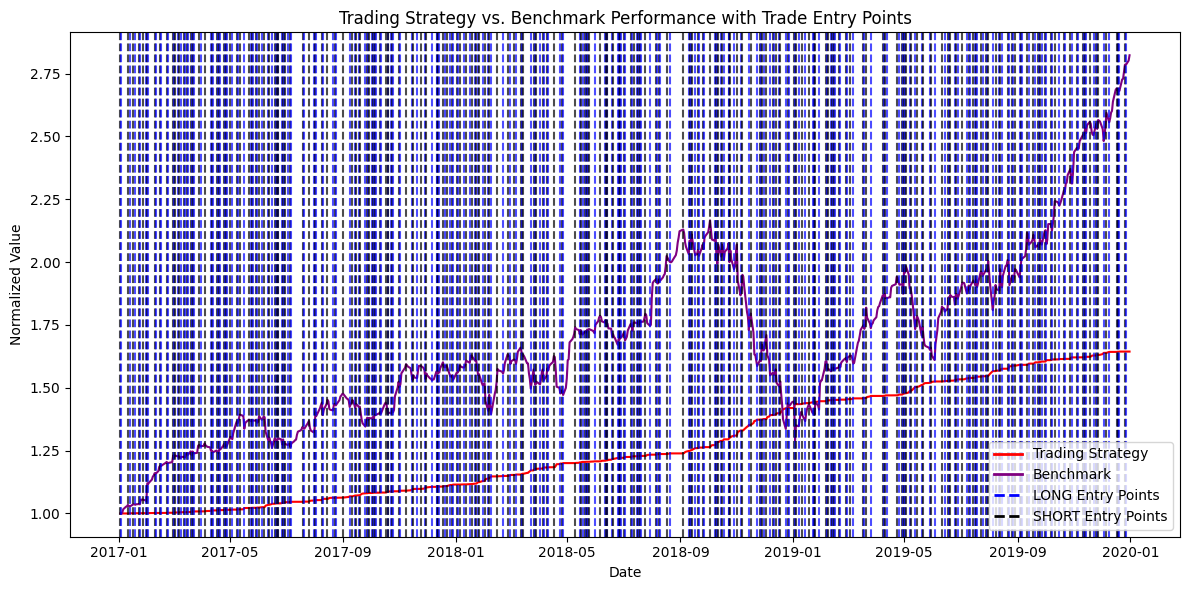

In [246]:
plot(trades_df, values_df, "AAPL")